<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/main/CodigoSantino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Criado em Domingo 1 dezembro 16:43:44 2019

@author: santinobitaraes
"""

from keras.utils.vis_utils import plot_model
from keras.models import Sequential # modelo da rede neural
from keras.layers import Dense, Dropout, LSTM # tipos de camadas que serao usadas
from sklearn.preprocessing import MinMaxScaler # normalizados de dados
#from keras.utils import plot_model # usado para plotar modelo da rede neural
import numpy as np # permite trabalhar com vetores e matrizes
import pandas as pd # permite manipulacao e analise de dados
import matplotlib.pyplot as plt # ferramenta para plotagem
import warnings

warnings.filterwarnings('ignore') # ignora avisos desnecessarios

# funcoes para calcular as metricas
def rmse(targets, forecasts):

  if isinstance(targets, list):
    targets = np.array(targets)
  if isinstance(forecasts, list):
    forecasts = np.array(forecasts)
  return np.sqrt(np.nanmean((targets - forecasts) ** 2))

def mape(targets, forecasts):
  if isinstance(targets, list):
    targets = np.array(targets)
  if isinstance(forecasts, list):
    forecasts = np.array(forecasts)
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts),targets))) * 100

def UStatistic(targets, forecasts):
  if not isinstance(forecasts, (list, np.ndarray)):
    forecasts = np.array([forecasts])
  else:
    forecasts = np.array(forecasts)

  if not isinstance(targets, (list, np.ndarray)):
    targets = np.array([targets])
  else:
    targets = np.array(targets)

  l = forecasts.size
  l = 2 if l == 1 else l

  naive = []
  y = []
  for k in np.arange(0, l - 1):
    y.append(np.subtract(forecasts[k], targets[k]) ** 2)
    naive.append(np.subtract(targets[k + 1], targets[k]) ** 2)
  return np.sqrt(np.divide(np.nansum(y), np.nansum(naive)))


In [12]:
# importa os dados
df = pd.read_excel('https://query.data.world/s/ubbxamr7q7tyi3fyg7wu664ggwq3ju')

# dados treinamento
qtde_valores_modelo = 200 # quantidade de valores da serie que serao usados para criar o modelo
base_treinamento = df.iloc[0:qtde_valores_modelo, 1:2].values # intervalo de dados para treinamento

# carrega os dados para testar a rede
base_teste = df.iloc[qtde_valores_modelo:224, 1:2].values # intervalo de dados para teste da rede neural
base_completa = df.iloc[0:224, 1:2].values # carrega a base completa


normalizador = MinMaxScaler(feature_range=(0, 1)) # configura o normalizador entre 0 e 1
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento) # faz a normalizacao dos dados

# carrega os dados para testar a rede
base_teste = df.iloc[qtde_valores_modelo:224, 1:2].values # intervalo de dados para teste da rede neural
base_completa = df.iloc[0:224, 1:2].values # carrega a base completa

normalizador = MinMaxScaler(feature_range=(0, 1)) # configura o normalizador entre 0 e 1
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
# faz a normalizacao dos dados

data_rmse = [] # inicia a variavel erro rmse como nula
data_mape = [] # inicia a variavel erro mape como nula
data_u = [] # inicia a variavel de avaliacao u como nula
previsores = [] # variavel que recebe a entrada da rede neural
valor_real = [] # variavel que recebe o valor real de cada previsao que sera feita no treinamento

qtde_valores_passado = 1 # quantidade de valores do passado que sera usado para prever um passo a frente
qtde_neuronios = 28 # neuronios nas camadas ocutas

# cria uma base de dados com entradas (previsores) e tags (valor_real) para o treinar a rede.
for i in range(qtde_valores_passado, len(base_treinamento)):
  previsores.append(base_treinamento_normalizada[i - qtde_valores_passado:i, 0])
  valor_real.append(base_treinamento_normalizada[i, 0])

previsores, valor_real = np.array(previsores), np.array(valor_real) # passa os valores para array somente

# transforma os valores para um formato que keras nescessita
# previsores -> sao os valores que irao ser transformados
# previsores.shape[0] -> tamanho total da base de dados
# previsores.shape[1] -> qtde de valores que serao usados para prever
# 1 -> 1 entrada de dados
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1)) # prepara os valores

regressor = Sequential() # cria a rede neural

# camada de entrada e camada oculta da rede neural
# units -> numero de neuronios ou celulas de memoria na camada
# return_sequences = True, -> indica que deve passar informacao pra frente para outras camadas
# input_shape --> valores na primeira camada
regressor.add(LSTM(units = qtde_neuronios, return_sequences = True,
input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3)) # zera 30% dos valores, isso ajuda evitar overfiting

# segunda camada oculta
regressor.add(LSTM(units = qtde_neuronios))
regressor.add(Dropout(0.3))

# camada saida
# units -> uma saida
# activation -> funcao de ativacao linear
regressor.add(Dense(units = 1, activation = 'linear' ))

# configura o otimizador da rede neural
# optimizer -> otimizador usado pela rede
# loss --> usado para ajuste dos pesos
# metrics --> para entender os resultados
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

# plota a rede neural
plot_model(regressor, to_file = 'model.png', show_shapes = 'true', expand_nested = 'true')

# treinamento da rede
# bath_size -> batch indica quantos registros passamos para o algoritmo fazer a atualizacao dos pesos.
# Nesse caso, a base completa e dividida em batches com 2 registros e apos calcular o erro para os 2
# e que os pesos sao atualizados
regressor.fit(previsores, valor_real, epochs = 100, batch_size = 2)

# prepara as novas entradas para testar na rede neural
entradas = base_completa[len(base_completa) - len(base_teste) - qtde_valores_passado:]
entradas = entradas.reshape(-1, 1) # somente para ficar no formato do numpy
entradas = normalizador.transform(entradas) # normaliza entre 0 e 1

X_teste = [] # variavel que vai receber as novas entradas para rede neural

# prepara os valores para entrar na rede
for i in range(qtde_valores_passado, len(entradas)):
  X_teste.append(entradas[i - qtde_valores_passado:i, 0])

X_teste = np.array(X_teste)

# prepara os valores para entrada de acordo com o pacote keras
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

# realiza previsoes
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes) # desnormaliza os valores

# calcula as metricas
rmse_v = rmse(base_teste, previsoes)
mape_v = mape(base_teste, previsoes)
u = UStatistic(base_teste, previsoes)


data_rmse.append(rmse_v)
data_mape.append(mape_v)
data_u.append(u)



Epoch 1/100
100/100 [==============================] - 5s 7ms/step - loss: 0.1195 - mean_absolute_error: 0.2833
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0348 - mean_absolute_error: 0.1461
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0281 - mean_absolute_error: 0.1364
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0282 - mean_absolute_error: 0.1334
Epoch 5/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0282 - mean_absolute_error: 0.1305
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0271 - mean_absolute_error: 0.1286
Epoch 7/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0270 - mean_absolute_error: 0.1311
Epoch 8/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0252 - mean_absolute_error: 0.1260
Epoch 9/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0242 - mean_absolute_err

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


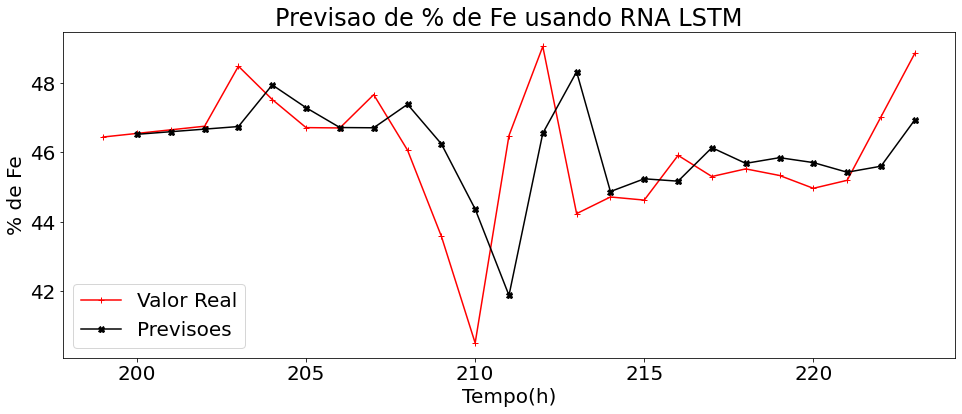

,RMSE,MAPE,U
0,1.832955,2.77626,0.883798


In [13]:
# plota os resultados

# vetor para o eixo x do grafico
ttr = list(range(len(base_treinamento)))
tts = list(range(len(base_treinamento) - qtde_valores_passado, len(base_completa)))
tts1 = tts[qtde_valores_passado:]

# dados para o teste
data_test = base_completa[len(base_completa) - len(base_teste) - qtde_valores_passado:]
data_test = data_test.transpose().tolist()
data_test = data_test[0]

plt.rcParams.update({'font.size': 20}) # configura a fonte do texto do grafico
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16, 6]) # tamanho da figura
plt.plot(tts, data_test, color = 'red', label = 'Valor Real', marker = "+")
# plota os dados reais
plt.plot(tts1, previsoes, color = 'black', label = 'Previsoes', marker = "X") # plota os dados preditos
plt.title('Previsao de % de Fe usando RNA LSTM')
plt.xlabel('Tempo(h)')
plt.ylabel('% de Fe')
plt.legend()
plt.savefig('prev_LSTM_Fe.eps', format = 'eps', bbox_inches='tight') #salva em uma figura
plt.show()

# apresenta as metricas
rmse_v = rmse(base_teste, previsoes)
mape_v = mape(base_teste, previsoes)
u = UStatistic(base_teste, previsoes)
rows = []
rows.append([rmse_v, mape_v, u])
pd.DataFrame(rows, columns=['RMSE', 'MAPE', 'U'])